# Option Data Visualization Tool

In this notebook, you will be able to visualize the price changes of options on any security of your choice over time, with calculations based on the Black-Scholes option pricing model. You can use it to judge the impact of various factors on the profitability of purchasing an option, such as the implied volatility (IV) - a factor which new investors often overlook.

## How to Use the Notebook

This notebook can be used on any option and all the user needs to do is enter the strike price, underlying price, IV, and expiration date then click Cell --> Run All.

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.linear_model
from scipy.stats import norm
from scipy.optimize import minimize
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import datetime

np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)
%matplotlib inline


In [208]:
def bs(s,x,r,t,v):
    d1 = ((np.log(s/x) + (r + (v**2)/2) * t)) / (v * np.sqrt(t))
    d2 = ((np.log(s/x) + (r - (v**2)/2) * t)) / (v * np.sqrt(t))
    price = s * norm.cdf(d1) - (x * np.exp(-r * t) * norm.cdf(d2))
    return price


In [209]:
# ENTER CURRENT PRICE OF UNDERLYING STOCK HERE
curr_price = ...

In [210]:
# ENTER STRIKE PRICE OF OPTION HERE
strike = ...

In [211]:
# CURRENT US 3 MONTH TREASURY BOND RISK FREE INTEREST RATE - DON'T CHANGE
rate = 0.001

In [212]:
#ENTER EXP DATE HERE - FORMAT (MM/DD/YYYY) AS SHOWN
date = '09/18/2020'

In [213]:
month, day, year = map(int, date.split('/'))

In [214]:
date_formatted = datetime.date(year, month, day)
days_exp = (date_formatted - datetime.date.today()).days

In [215]:
years_exp = days_exp / 365

In [216]:
#ENTER IMPLIED VOLATILITY WITHOUT % SYMBOL HERE (78.25% --> 78.25)
iv = ...

In [217]:
iv = iv / 100

In [218]:
curr_value = bs(curr_price, strike, rate, years_exp, iv)
curr_value

188.04272715463094

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in double_scalars

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in double_scalars



Text(0.5, 1.0, 'Decay of Option Price with 89.26% IV (Fixed Underlying Price)')

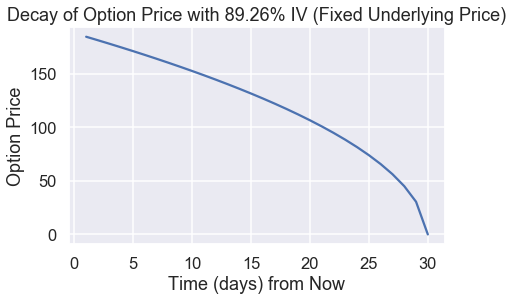

In [219]:
y = [bs(curr_price, strike, rate, x/365, iv) for x in range(days_exp)]
plt.plot((days_exp - np.arange(days_exp)), y)
plt.xlabel('Time (days) from Now')
plt.ylabel('Option Price')
plt.title('Decay of Option Price with ' + str(iv * 100) + '% IV (Fixed Underlying Price)')

In [220]:
def descent(bs, x, days, num_iter=150, margin=0.01*curr_value):
    guess = x + x * (iv / 365) * days
    alpha = iv/365 * x * 0.02 * days
    new_price = bs(guess, strike, rate, (days_exp - days)/365, iv)
    prev = guess
    loss = lambda x: np.abs(curr_value - x)
    for _ in range(num_iter):
        prev = prev + alpha
        curr_loss = loss(bs(prev, strike, rate, (days_exp - days)/365, iv))
        if np.round(curr_loss, 2) <= margin:
            return prev
    return prev
lower_limit = curr_price * 0.8
upper_limit = curr_price * 1.2

# SIMPLE P/L BOUNDARY
The following cell will generate a simple P/L boundary for the option with the yellow line representing the option's implied move for the underlying stock. The green region indicates the profitable region for your option (IV held constant) and the red region indicates the loss region.

Text(0.5, 1.0, 'Estimated Option P/L Boundary')

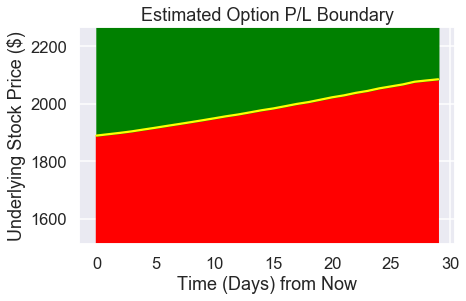

In [229]:
desc_test = [descent(bs, curr_price, x) for x in range(days_exp)]
plt.plot(range(days_exp), desc_test, color='yellow')
plt.ylim(curr_price * 0.8, curr_price * 1.2)
plt.fill_between(range(days_exp), desc_test, color='red')
plt.fill_between(range(days_exp), desc_test, y2=curr_price * 1.2, color='green')
plt.xlabel('Time (Days) from Now')
plt.ylabel('Underlying Stock Price ($)')
plt.title('Estimated Option P/L Boundary')

In [230]:
price_vals = np.linspace(lower_limit, upper_limit, 100)
price_vals_mat = np.repeat(np.linspace(lower_limit, upper_limit, 100), days_exp)
time_vals = []
[time_vals.extend(range(days_exp)) for x in range(100)]
time_vals = np.array(time_vals)
xy_mat = np.vstack((time_vals, price_vals_mat)).T
z_vals = []
z_vals = np.array([[np.round(bs(price, strike, rate, (days_exp - x)/365, iv), 2) for x in range(days_exp)] for price in price_vals])
z_vals = z_vals.flatten()

In [223]:
xyz_mat = np.vstack((time_vals, price_vals_mat, z_vals)).T
xyz_mat

array([[0.0000e+00, 1.5120e+03, 4.3960e+01],
       [1.0000e+00, 1.5120e+03, 4.2030e+01],
       [2.0000e+00, 1.5120e+03, 4.0100e+01],
       ...,
       [2.7000e+01, 2.2680e+03, 3.6886e+02],
       [2.8000e+01, 2.2680e+03, 3.6817e+02],
       [2.9000e+01, 2.2680e+03, 3.6801e+02]])

In [224]:
xyz_df = pd.DataFrame(data=xyz_mat, columns = ['Days from Now', 'Underlying Price', 'Option Price'])
xyz_df.head()

,Days from Now,Underlying Price,Option Price
0,0.0,1512.0,43.96
1,1.0,1512.0,42.03
2,2.0,1512.0,40.10
3,3.0,1512.0,38.16
4,4.0,1512.0,36.22


In [225]:
xyz_df['Profitable'] = xyz_df['Option Price'] >= curr_value
xyz_df['Profit'] = xyz_df['Option Price'] - curr_value
xyz_df.head()

,Days from Now,Underlying Price,Option Price,Profitable,Profit
0,0.0,1512.0,43.96,False,-144.082727
1,1.0,1512.0,42.03,False,-146.012727
2,2.0,1512.0,40.10,False,-147.942727
3,3.0,1512.0,38.16,False,-149.882727
4,4.0,1512.0,36.22,False,-151.822727


# 3D P/L BOUNDARIES
The following cells will generate interactive 3D P/L boundaries for the option. The first 3D plot will display a standard P/L boundary based on time, underlying price, and option price. The second 3D plot will display the exact profit of an option based on time and underlying price. You can click through the 2 plot to view individual values.

The green region indicates the profitable region for your option (IV held constant) and the red region indicates the loss region.

In [231]:
fig = px.scatter_3d(xyz_df, x='Days from Now', y='Underlying Price', z='Option Price', color='Profitable', 
              color_discrete_map={True:'#00ff00', False: '#ff0000'}, 
                    title='P/L Boundary Based on Time, Option Price, and Underlying Price'
    )
fig.show()

In [232]:
fig2 = px.scatter_3d(xyz_df, x='Days from Now', y='Underlying Price', z='Profit', color='Profitable', 
              color_discrete_map={True:'#00ff00', False: '#ff0000'}, 
                    title='Profit Based on Time, Option Price, and Underlying Price'
    )
fig2.show()